In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import csv
import shapely
import shapely.wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import numpy as np
import geopy
from datetime import datetime
import os, csv, shapely, shapely.wkt, descartes, geopy, pickle, cloudpickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.options.display.float_format = '{:.4f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
import descartes
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn import metrics as skm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fairlearn.metrics import equalized_odds_ratio, MetricFrame, demographic_parity_difference, demographic_parity_ratio, selection_rate, equalized_odds_difference, true_positive_rate, false_positive_rate
from fairlearn.reductions import BoundedGroupLoss, ZeroOneLoss, ExponentiatedGradient, SquareLoss, AbsoluteLoss, GridSearch, DemographicParity, ErrorRate, EqualizedOdds
from sklearn.model_selection import KFold

# pd.set_option('display.max_rows', 10)
# sns.set()
# sns.color_palette("ch:s=.25,rot=-.25")
np.set_printoptions(suppress=True)


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
DATA_PATH = 'preprocess/'

In [3]:
CITY = "N_"
save_dir = CITY + 'clas_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
if not os.path.exists(save_dir_preprocess):
    os.makedirs(save_dir_preprocess)

if not os.path.exists(save_dir_models):
    os.makedirs(save_dir_models)
    
if not os.path.exists(save_dir_forecast):
    os.makedirs(save_dir_forecast)
    
if not os.path.exists(save_dir_fairst):
    os.makedirs(save_dir_fairst)

In [5]:
df_census_raw = pd.read_csv(DATA_PATH + "cell_census.csv", index_col = 0)
df_walk_score_raw = pd.read_csv(DATA_PATH + "walk_score.csv", index_col = 0)
df_outflow_raw = pd.read_csv(DATA_PATH + 'df_outflow_monthly_cell.csv', index_col = 0)
df_weather_sort = pd.read_csv(DATA_PATH + "df_weather_sort.csv", index_col = 0)
df_walk_score = pd.read_csv(DATA_PATH + 'df_walk_score.csv', index_col = 0)

In [6]:
df_census =  df_census_raw.merge(df_walk_score, on = 'cell_num')
# df_census.to_csv(DATA_PATH + "df_census.csv")

In [7]:
df_census_copy = df_census.copy()
# make df_income for fairST
# training set
df_census_copy["income_group"] = 0
for row, col in df_census_copy.iterrows():
    if df_census_copy.loc[row]["median_hh_income"] > 50000:
        df_census_copy.at[row, "income_group"] = 1
# df_census_copy[["cell_num", "income_group"]].to_csv(os.path.join(save_dir_fairst, "df_income.csv"))

In [8]:
for row,col in df_census.iterrows():
    df_census.at[row, 'geometry'] = shapely.wkt.loads(df_census.loc[row]['geometry'])
    df_census.at[row, 'centroid'] = shapely.wkt.loads(df_census.loc[row]['centroid'])

In [9]:
df_geo = df_census[["cell_num", "geometry", "centroid"]]

### merge

In [10]:
df_all_merge1 = df_outflow_raw.merge(df_census, on = 'cell_num', how = 'left')
df_all_merge1

,cell_num,year,month,outflow,geometry,centroid,stations,stations_id_list,census_id,total_population,total_housing_units,population_over_16,population_over_16_in_labor,population_over_16_employed,population_over_16_unemployed,num_works_over_16,car_truck_van_alone,car_truck_van_carpooled,public_transit,walked,other_means,wfh,mean_travel_time_to_work,median_hh_income,mean_hh_income,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,4605,2017,10,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4784,2017,8,1143,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000
2,4784,2017,9,1010,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000
3,4784,2017,10,712,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000
4,4784,2018,4,2,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14102,7205,2019,11,28,POLYGON ((-73.90669297117601 40.69811829563462...,POINT (-73.90439757690744 40.7004136899032),3.0000,"[3878, 3896, 3884]",36081055100.0000,4244.0000,1783.0000,3419.0000,2601.0000,2432.0000,169.0000,2361.0000,398.0000,31.0000,1741.0000,114.0000,22.0000,55.0000,44.0000,75280.0000,78006.0000,99.0000,98.0000,78.0000,16.0000,4.0000,0.0000,20.0000
14103,7205,2019,12,84,POLYGON ((-73.90669297117601 40.69811829563462...,POINT (-73.90439757690744 40.7004136899032),3.0000,"[3878, 3896, 3884]",36081055100.0000,4244.0000,1783.0000,3419.0000,2601.0000,2432.0000,169.0000,2361.0000,398.0000,31.0000,1741.0000,114.0000,22.0000,55.0000,44.0000,75280.0000,78006.0000,99.0000,98.0000,78.0000,16.0000,4.0000,0.0000,20.0000
14104,7206,2019,12,55,POLYGON ((-73.90669297117601 40.70270908417177...,POINT (-73.90439757690744 40.70500447844034),3.0000,"[3877, 3902, 3909]",36081058900.0000,5296.0000,1724.0000,4096.0000,2792.0000,2699.0000,93.0000,2646.0000,390.0000,66.0000,1778.0000,310.0000,20.0000,82.0000,42.9000,62083.0000,81005.0000,96.0000,96.0000,74.0000,17.0000,4.0000,0.0000,21.0000
14105,7298,2019,11,41,POLYGON ((-73.90210218263886 40.69811829563462...,POINT (-73.89980678837027 40.7004136899032),2.0000,"[3876, 3875]",36081055700.0000,4275.0000,1491.0000,3305.0000,2350.0000,2285.0000,65.0000,2281.0000,424.0000,51.0000,1646.0000,97.0000,36.0000,27.0000,46.4000,65799.0000,73238.0000,99.0000,96.0000,75.0000,16.0000,4.0000,0.0000,20.0000


In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_all_merge1.isna().sum())

cell_num                            0
year                                0
month                               0
outflow                             0
geometry                          324
centroid                          324
stations                          324
stations_id_list                  324
census_id                         324
total_population                 2326
total_housing_units              2326
population_over_16               2326
population_over_16_in_labor      2326
population_over_16_employed      2326
population_over_16_unemployed    2326
num_works_over_16                2326
car_truck_van_alone              2326
car_truck_van_carpooled          2326
public_transit                   2326
walked                           2326
other_means                      2326
wfh                              2326
mean_travel_time_to_work         2326
median_hh_income                 2326
mean_hh_income                   2326
walk_score                        324
transit_scor

In [12]:
df_all_merge1.drop(df_all_merge1[df_all_merge1.geometry.isnull()].index, inplace = True)

In [14]:
df_all_merge1 = df_all_merge1.fillna(df_all_merge1.mean())
df_all_merge1

,cell_num,year,month,outflow,geometry,centroid,stations,stations_id_list,census_id,total_population,total_housing_units,population_over_16,population_over_16_in_labor,population_over_16_employed,population_over_16_unemployed,num_works_over_16,car_truck_van_alone,car_truck_van_carpooled,public_transit,walked,other_means,wfh,mean_travel_time_to_work,median_hh_income,mean_hh_income,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
1,4784,2017,8,1143,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000
2,4784,2017,9,1010,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000
3,4784,2017,10,712,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000
4,4784,2018,4,2,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000
5,4784,2018,5,624,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14102,7205,2019,11,28,POLYGON ((-73.90669297117601 40.69811829563462...,POINT (-73.90439757690744 40.7004136899032),3.0000,"[3878, 3896, 3884]",36081055100.0000,4244.0000,1783.0000,3419.0000,2601.0000,2432.0000,169.0000,2361.0000,398.0000,31.0000,1741.0000,114.0000,22.0000,55.0000,44.0000,75280.0000,78006.0000,99.0000,98.0000,78.0000,16.0000,4.0000,0.0000,20.0000
14103,7205,2019,12,84,POLYGON ((-73.90669297117601 40.69811829563462...,POINT (-73.90439757690744 40.7004136899032),3.0000,"[3878, 3896, 3884]",36081055100.0000,4244.0000,1783.0000,3419.0000,2601.0000,2432.0000,169.0000,2361.0000,398.0000,31.0000,1741.0000,114.0000,22.0000,55.0000,44.0000,75280.0000,78006.0000,99.0000,98.0000,78.0000,16.0000,4.0000,0.0000,20.0000
14104,7206,2019,12,55,POLYGON ((-73.90669297117601 40.70270908417177...,POINT (-73.90439757690744 40.70500447844034),3.0000,"[3877, 3902, 3909]",36081058900.0000,5296.0000,1724.0000,4096.0000,2792.0000,2699.0000,93.0000,2646.0000,390.0000,66.0000,1778.0000,310.0000,20.0000,82.0000,42.9000,62083.0000,81005.0000,96.0000,96.0000,74.0000,17.0000,4.0000,0.0000,21.0000
14105,7298,2019,11,41,POLYGON ((-73.90210218263886 40.69811829563462...,POINT (-73.89980678837027 40.7004136899032),2.0000,"[3876, 3875]",36081055700.0000,4275.0000,1491.0000,3305.0000,2350.0000,2285.0000,65.0000,2281.0000,424.0000,51.0000,1646.0000,97.0000,36.0000,27.0000,46.4000,65799.0000,73238.0000,99.0000,96.0000,75.0000,16.0000,4.0000,0.0000,20.0000


In [15]:
df_all_merge2 = df_all_merge1.merge(df_weather_sort, on = ["year", "month"])
df_all_merge2.head()

,cell_num,year,month,outflow,geometry,centroid,stations,stations_id_list,census_id,total_population,total_housing_units,population_over_16,population_over_16_in_labor,population_over_16_employed,population_over_16_unemployed,num_works_over_16,car_truck_van_alone,car_truck_van_carpooled,public_transit,walked,other_means,wfh,mean_travel_time_to_work,median_hh_income,mean_hh_income,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,temp
0,4784,2017,8,1143,POLYGON ((-74.02605347314211 40.68434593002317...,POINT (-74.02375807887353 40.68664132429174),1.0000,[3479],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000,74.0000
1,4877,2017,8,1530,POLYGON ((-74.02146268460496 40.68434593002317...,POINT (-74.01916729033638 40.68664132429174),1.0000,[3182],36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23.0000,46.0000,39.0000,11.0000,0.0000,2.0000,13.0000,74.0000
2,4967,2017,8,815,"POLYGON ((-74.0168718960678 40.67057356441172,...",POINT (-74.01457650179923 40.6728689586803),1.0000,[3353],36047005301.0000,4500.0721,2412.5691,3870.2444,2668.2709,2537.2667,129.9449,2489.1296,164.3999,39.4105,1503.4652,462.9957,140.8751,177.9833,31.5011,98022.6084,148186.4719,74.0000,51.0000,92.0000,11.0000,4.0000,1.0000,16.0000,74.0000
3,4968,2017,8,1470,"POLYGON ((-74.0168718960678 40.67516435294887,...",POINT (-74.01457650179923 40.67745974721744),4.0000,"[3348, 3347, 3644, 3676]",36047005301.0000,4500.0721,2412.5691,3870.2444,2668.2709,2537.2667,129.9449,2489.1296,164.3999,39.4105,1503.4652,462.9957,140.8751,177.9833,31.5011,98022.6084,148186.4719,88.0000,50.0000,94.0000,11.0000,0.0000,2.0000,13.0000,74.0000
4,4971,2017,8,1917,"POLYGON ((-74.0168718960678 40.68893671856032,...",POINT (-74.01457650179923 40.6912321128289),2.0000,"[3181, 3254]",36061000500.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,21.0000,70.0000,32.0000,28.0000,6.0000,5.0000,39.0000,74.0000


### income group

In [16]:
df_all_merge2["median_hh_income"].describe()

count    13783.0000
mean     98022.6084
std      51097.6488
min          0.0000
25%      61607.0000
50%      98022.6084
75%     133960.0000
max     250000.0000
Name: median_hh_income, dtype: float64

In [17]:
# training set
df_all_merge2["income_group"] = 0
for row, col in df_all_merge2.iterrows():
    if df_all_merge2.loc[row]["median_hh_income"] > 50000:
        df_all_merge2.at[row, "income_group"] = 1
df_all_merge2.drop(columns = ["median_hh_income"], inplace = True)

Text(0, 0.5, 'Count')

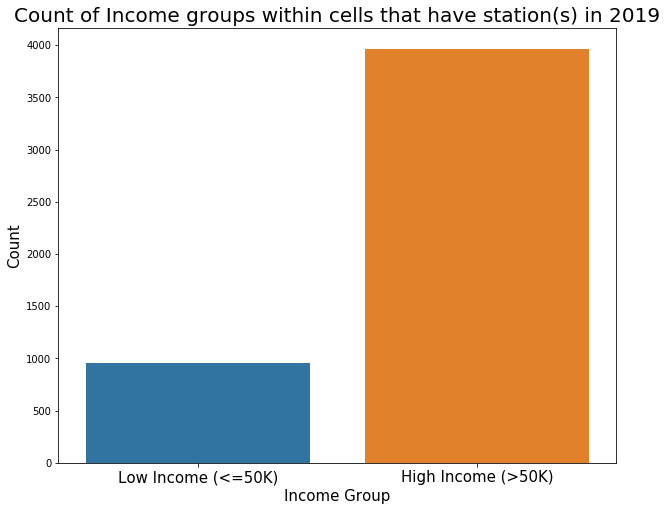

In [18]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot(df_all_merge2[df_all_merge2.year == 2019]["income_group"])
plt.title("Count of Income groups within cells that have station(s) in 2019", fontsize = 20)
plt.xticks([0, 1], ["Low Income (<=50K)", "High Income (>50K)"], fontsize = 15)
plt.xlabel("Income Group", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
# plt.savefig(os.path.join(save_dir_preprocess, CITY +"income_group_2019"))

### 2.2 outflow class

In [19]:
df = df_all_merge2
df["outflow_class"] = 0
for row, col in df.iterrows():
        
    if df.loc[row]["outflow"] > df.outflow.mean():
        df.at[row, "outflow_class"] = 1
        
df.drop(columns = ["outflow"], inplace = True)

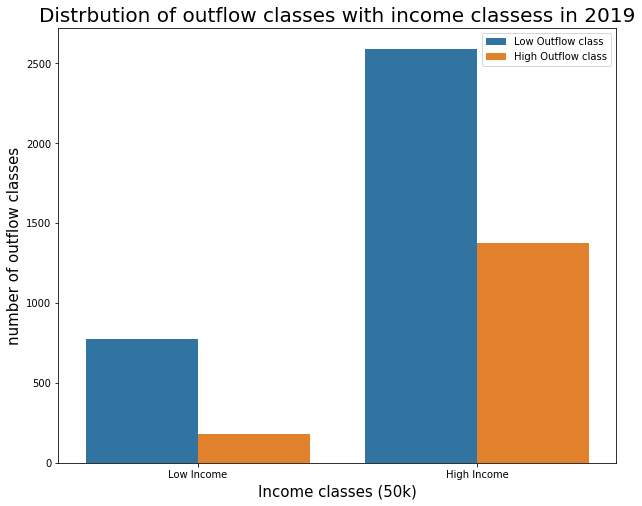

In [20]:
# sns.set(rc={'figure.figsize':(8, 6)})
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.countplot(df[df.year == 2019]['income_group'], hue = df[df.year == 2019]["outflow_class"])
# ax.set_title('Count of outflow classes for two income groups')
ax.set_ylabel('number of outflow classes', fontsize = 15)
ax.set_xlabel("Income classes (50k)", fontsize = 15)
plt.legend(["Low Outflow class", "High Outflow class"])

# # plt.savefig("fig1")
plt.xticks([0, 1], ['Low Income', 'High Income'])
plt.title("Distrbution of outflow classes with income classess in 2019", fontsize = 20)
plt.savefig(os.path.join(save_dir_preprocess, CITY+"outflow_income_group_2019"))

In [21]:
df_low_income = df[df.year == 2019][df[df.year == 2019]["income_group"] == 0]
df_high_income = df[df.year == 2019][df[df.year == 2019]["income_group"] == 1]

low_income_low_outflow = len(df_low_income[df_low_income["outflow_class"] == 0])/len(df_low_income)
low_income_high_outflow = len(df_low_income[df_low_income["outflow_class"] == 1])/len(df_low_income)

high_income_low_outflow = len(df_high_income[df_high_income["outflow_class"] == 0])/len(df_high_income)
high_income_high_outflow = len(df_high_income[df_high_income["outflow_class"] == 1])/len(df_high_income)

fig2_df = pd.DataFrame({"Outflow": [low_income_high_outflow*100, high_income_high_outflow*100],
                       "Income": ["Low", "High"]})
fig2_df

,Outflow,Income
0,19.1023,Low
1,34.6445,High


Text(0.5, 1.0, 'Percentage of high outflow classes in 2019')

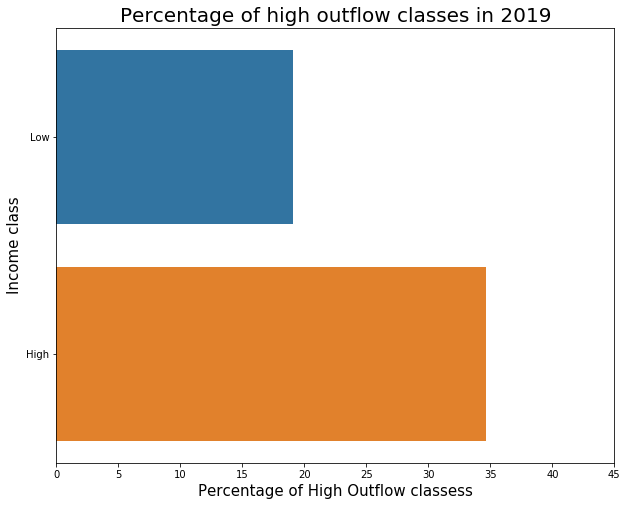

In [22]:
# sns.set(rc={'figure.figsize':(8, 6)})
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.barplot(data = fig2_df, x = 'Outflow', y = 'Income')

ax.set_ylabel('Income class', fontsize = 15)
ax.set_xlabel("Percentage of High Outflow classess", fontsize = 15)
ax.set_xlim(0, 45)
plt.title("Percentage of high outflow classes in 2019", fontsize = 20)
# plt.savefig("Figures/Fig2b.svg")

### 2.3 train

In [24]:
features_col = ["cell_num", 'year', 'month', 'outflow_class', 'stations', 
               'total_population', 'total_housing_units', 'population_over_16_employed',
               'population_over_16_unemployed', 'num_works_over_16',
               'car_truck_van_alone', 'car_truck_van_carpooled', 'public_transit',
               'walked', 'other_means', 'wfh', 'mean_travel_time_to_work',
                'walk_score', 'transit_score', 'bike_score', 'nearby_bus',
                'nearby_rail', 'nearby_other', 'nearby_routes', 'temp',
               'income_group']
df = df[features_col]
df

,cell_num,year,month,outflow_class,stations,total_population,total_housing_units,population_over_16_employed,population_over_16_unemployed,num_works_over_16,car_truck_van_alone,car_truck_van_carpooled,public_transit,walked,other_means,wfh,mean_travel_time_to_work,walk_score,transit_score,bike_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,temp,income_group
0,4784,2017,8,0,1.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,38.0000,32.0000,10.0000,0.0000,2.0000,12.0000,74.0000,0
1,4877,2017,8,0,1.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23.0000,46.0000,39.0000,11.0000,0.0000,2.0000,13.0000,74.0000,0
2,4967,2017,8,0,1.0000,4500.0721,2412.5691,2537.2667,129.9449,2489.1296,164.3999,39.4105,1503.4652,462.9957,140.8751,177.9833,31.5011,74.0000,51.0000,92.0000,11.0000,4.0000,1.0000,16.0000,74.0000,1
3,4968,2017,8,0,4.0000,4500.0721,2412.5691,2537.2667,129.9449,2489.1296,164.3999,39.4105,1503.4652,462.9957,140.8751,177.9833,31.5011,88.0000,50.0000,94.0000,11.0000,0.0000,2.0000,13.0000,74.0000,1
4,4971,2017,8,0,2.0000,0.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,21.0000,70.0000,32.0000,28.0000,6.0000,5.0000,39.0000,74.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13778,6552,2015,10,0,1.0000,2991.0000,1456.0000,1842.0000,79.0000,1788.0000,205.0000,66.0000,1205.0000,126.0000,168.0000,18.0000,49.2000,90.0000,95.0000,77.0000,14.0000,7.0000,0.0000,21.0000,58.0000,1
13779,6553,2015,10,0,2.0000,3093.0000,1303.0000,1442.0000,53.0000,1410.0000,118.0000,134.0000,999.0000,80.0000,66.0000,13.0000,43.9000,97.0000,99.0000,78.0000,15.0000,7.0000,0.0000,22.0000,58.0000,0
13780,6563,2015,10,0,2.0000,4500.0721,2412.5691,2537.2667,129.9449,2489.1296,164.3999,39.4105,1503.4652,462.9957,140.8751,177.9833,31.5011,77.0000,99.0000,74.0000,10.0000,13.0000,0.0000,23.0000,58.0000,1
13781,6564,2015,10,0,1.0000,4500.0721,2412.5691,2537.2667,129.9449,2489.1296,164.3999,39.4105,1503.4652,462.9957,140.8751,177.9833,31.5011,88.0000,100.0000,85.0000,16.0000,21.0000,0.0000,37.0000,58.0000,1


In [25]:
# Train Test split
df_1518 = df[df["year"].isin([2015, 2016, 2017, 2018])] # 1032
df_19 = df[df["year"].isin([2019])]

df_1518 = df_1518.drop(columns = ["year"])
df_19 = df_19.drop(columns = ["year"])

In [26]:
X_train = df_1518.drop(columns = ["outflow_class", "cell_num"])
X_test = df_19.drop(columns = ["outflow_class", "cell_num"])

y_train = df_1518["outflow_class"]
y_test = df_19["outflow_class"]

A_train = df_1518["income_group"]
A_test = df_19["income_group"]

y_test_cell_num = df_19[["cell_num", "income_group"]]
y_test_cell_num

,cell_num,income_group
3825,4784,0
3826,4877,0
3827,4968,1
3828,4971,0
3829,4974,1
...,...,...
13537,7203,1
13538,7204,1
13539,7205,1
13540,7206,1


In [27]:
# reset index
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
A_train.reset_index(drop = True, inplace = True)
A_test.reset_index(drop = True, inplace = True)

X_train.to_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"))

### 3 Fairness models

In [29]:
# summary df
model_summary = pd.DataFrame(0, columns = ["accuracy", "accuracy_diff", "selection_rate", "selection_rate_diff"], 
                             index = ["random_forest", "exp_grad", "grid_search"])

# model_summary.to_csv(os.path.join(save_dir_models, "model_summary.csv"))

In [30]:
rf_best = pickle.load(open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb'))

accuracy         0.9377
selection_rate   0.2616
dtype: object
------------------------------
             accuracy selection_rate
income_group                        
0              0.9478         0.1451
1              0.9352         0.2897
------------------------------
accuracy: 0.93765
accuracy diff: 0.01261
selection_rate: 0.26158
selection_rate diff: 0.14462
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcba3b9b1d0>,
      dtype=object)

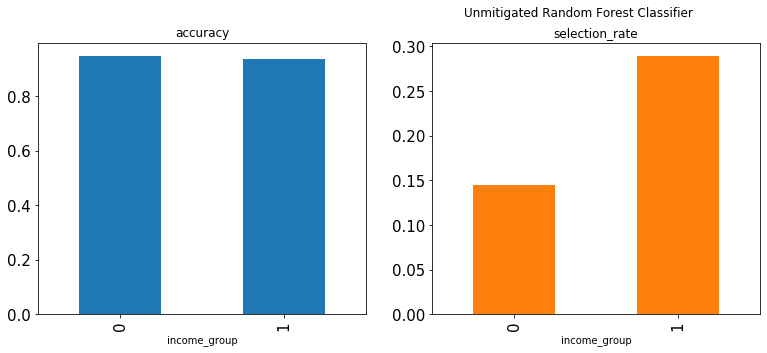

In [32]:
'''
TEST SET
'''
# rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf_gs = rf_best.predict(X_test)

# Metric evaluation
metric_frame_rf_gs = MetricFrame(metric = 
                                    {"accuracy": skm.accuracy_score,
                                     "selection_rate": selection_rate},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_rf_gs)

print(metric_frame_rf_gs.overall)
print("-"*30)
print(metric_frame_rf_gs.by_group)
print("-"*30)
print("accuracy:", "{:.5f}".format(metric_frame_rf_gs.overall["accuracy"]))
print("accuracy diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["accuracy"]))
print("selection_rate:", "{:.5f}".format(metric_frame_rf_gs.overall["selection_rate"]))
print("selection_rate diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["selection_rate"]))

print("-"*30)
model_summary.loc["random_forest", "accuracy"] = metric_frame_rf_gs.overall["accuracy"]
model_summary.loc["random_forest", "accuracy_diff"] = metric_frame_rf_gs.difference()["accuracy"]
model_summary.loc["random_forest", "selection_rate"] = metric_frame_rf_gs.overall["selection_rate"]
model_summary.loc["random_forest", "selection_rate_diff"] = metric_frame_rf_gs.difference()["selection_rate"]

# # save model
# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Unmitigated Random Forest Classifier', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY +"random_forest_metrics"))

### 3.2 Exponentiated Gradient (constraint: EqualizedOdds)

In [33]:
# diff_bound_l = np.arange(0, 100000, 2000)/10000000
# diff_bound_l = diff_bound_l[1:]
# diff_bound_l = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5]

diff_bound_l = np.linspace(0, 1, 100)
diff_bound_l
# diff_bound_l = [0.1, 0.2, 0.3, 0.4, 0.5]

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [1]:
# cross validation for EG
# implement K-fold cross validation

exp_grad_result = pd.DataFrame({"diff_bound": diff_bound_l})

for i in range(len(diff_bound_l)):
    cv_acc_ls = []
    cv_selection_rate_diff_ls = []
    
    print(i)
    diff_bound = diff_bound_l[i]
    
    # train-valid split
    kfold = KFold(3, shuffle = True, random_state = 42)
    for train, valid in kfold.split(X_train):
        # print("CV")
        X_train_exp = X_train.loc[train]
        y_train_exp = y_train.loc[train]
        A_train_exp = A_train.loc[train]

        X_valid = X_train.loc[valid]
        y_valid = y_train.loc[valid]
        A_valid = A_train.loc[valid]

        # avoid failure of optimization
        # try:
        # train
        # constraint = EqualizedOdds(difference_bound = diff_bound)
        constraint = DemographicParity(difference_bound = diff_bound)
        exp_grad = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
        try:
            exp_grad.fit(X_train_exp, y_train_exp, sensitive_features = A_train_exp)
            y_valid_pred = exp_grad.predict(X_valid, random_state = 42)

            # performance validation #
            metric_frame_eg_cv = MetricFrame(metric = 
                                                    {"accuracy": skm.accuracy_score,
                                                     "selection_rate": selection_rate},
                                             sensitive_features = A_valid, 
                                             y_true = y_valid, 
                                             y_pred = y_valid_pred)

            cv_acc_ls.append(metric_frame_eg_cv.overall["accuracy"])
            cv_selection_rate_diff_ls.append(metric_frame_eg_cv.difference()["selection_rate"])

        except:
            print("na")
            cv_acc_ls.append(np.nan)
            cv_selection_rate_diff_ls.append(np.nan)
            
    exp_grad_result.loc[i, "cv_avg_acc"] = np.nanmean(np.array(cv_acc_ls))
    exp_grad_result.loc[i, "cv_selection_rate_diff"] = np.nanmean(np.array(cv_selection_rate_diff_ls))

    
    # exp_grad_result.to_csv(os.path.join(save_dir_models, CITY+"exp_grad_valid_res.csv"))

In [3]:
# best_eg_index = exp_grad_result[exp_grad_result.cv_avg_mae_diff == exp_grad_result.cv_avg_mae_diff.min()].index[0]
# print("best upper bound for BGL:", diff_bound_l[best_eg_index])

# plot
plt.figure(figsize = (25, 8))
plt.plot(exp_grad_result.diff_bound, exp_grad_result.cv_selection_rate_diff)
plt.scatter(exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].diff_bound, exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].cv_selection_rate_diff, color = "red")
# plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
plt.xlabel("diff bound", fontsize = 15)
plt.ylabel("Selection rate difference", fontsize = 15)
plt.text(x = exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].diff_bound+0.0005, y = exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].cv_selection_rate_diff, s = 'min', color = "red")
plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
plt.title("Exponentiated Gradient cross validation result: MAE difference vs. 'upper_bound' in BGL ", fontsize = 18)
# plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_valid_res"))

In [43]:
best_diff = exp_grad_result.loc[exp_grad_result.cv_selection_rate_diff.argmin()].diff_bound

In [45]:
# predict on test set
constraint = DemographicParity(difference_bound = best_diff)
eg_best = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
eg_best.fit(X_train, y_train, sensitive_features = A_train)
y_pred_eg = eg_best.predict(X_test, random_state = 42)

In [46]:
# # save model
# Pkl_Filename = "exp_grad_SP.pkl"  
# with open(os.path.join(save_dir_models, CITY + Pkl_Filename), 'wb') as file:  
#     cloudpickle.dump(eg_best, file)

In [47]:
eg_best = pickle.load(open(os.path.join(save_dir_models, CITY + "exp_grad_SP.pkl"), 'rb'))
y_pred_eg = eg_best.predict(X_test, random_state = 42)

accuracy         0.9145
selection_rate   0.2729
dtype: object
------------------------------
             accuracy selection_rate
income_group                        
0              0.8800         0.2672
1              0.9228         0.2743
------------------------------
accuracy: 0.91450
accuracy diff: 0.04289
selection_rate: 0.27295
selection_rate diff: 0.00711
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcba443d910>,
      dtype=object)

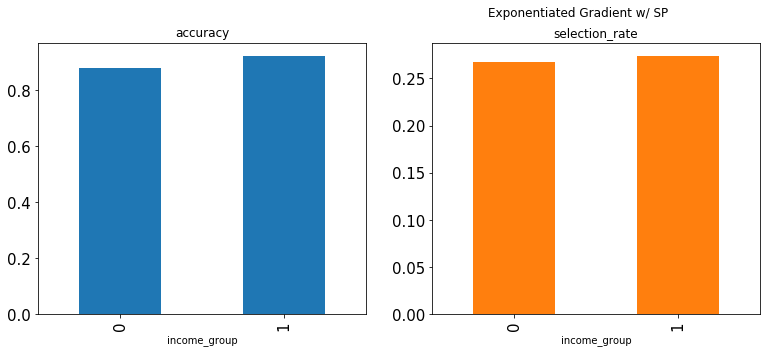

In [48]:
'''
TEST SET
'''
metric_frame_eg = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_eg)

print(metric_frame_eg.overall)
print("-"*30)
print(metric_frame_eg.by_group)
print("-"*30)
print("accuracy:", "{:.5f}".format(metric_frame_eg.overall["accuracy"]))
print("accuracy diff:", "{:.5f}".format(metric_frame_eg.difference()["accuracy"]))
print("selection_rate:", "{:.5f}".format(metric_frame_eg.overall["selection_rate"]))
print("selection_rate diff:", "{:.5f}".format(metric_frame_eg.difference()["selection_rate"]))

print("-"*30)

model_summary.loc["exp_grad", "accuracy"] = metric_frame_eg.overall["accuracy"]
model_summary.loc["exp_grad", "accuracy_diff"] = metric_frame_eg.difference()["accuracy"]
model_summary.loc["exp_grad", "selection_rate"] = metric_frame_eg.overall["selection_rate"]
model_summary.loc["exp_grad", "selection_rate_diff"] = metric_frame_eg.difference()["selection_rate"]


metric_frame_eg.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Exponentiated Gradient w/ SP', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY +"exp_grad_metric"))

### 3) Grid Search (constraint: BGL)

In [49]:
kfold = KFold(2, shuffle = True, random_state = 42)

# randomly get train valid set
for train, valid in kfold.split(X_train):
    # print("CV")
    X_train_gs = X_train.loc[train]
    y_train_gs = y_train.loc[train]
    A_train_gs = A_train.loc[train]

    X_valid = X_train.loc[valid]
    y_valid = y_train.loc[valid]
    A_valid = A_train.loc[valid]

In [50]:
# get all predictors according to best grid size
acc_all = []
selection_rate_diff_all = []
mitigator = GridSearch(estimator = rf_best,
                       constraints = DemographicParity(difference_bound = best_diff),
                       grid_size = 100)

mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
predictors = mitigator.predictors_

In [51]:
# get dominant model on valid set
for i in range(len(predictors)):
    metric_frame = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate},
                               sensitive_features = A_valid,
                               y_true = y_valid, 
                               y_pred = predictors[i].predict(X_valid))
    
    acc_all.append(metric_frame.overall["accuracy"])
    selection_rate_diff_all.append(metric_frame.difference()["selection_rate"])
    
# get dominant models
all_results = pd.DataFrame({"predictors:": predictors, "acc": acc_all, "diff": selection_rate_diff_all})

gs_dominant_final = []
for row in all_results.itertuples():
    '''
    want the models that have the high R^2 with low difference
    thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
    # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
    '''
    difference = all_results["diff"][all_results["acc"] >= row.acc]
    if row.diff <= difference.min():
        gs_dominant_final.append(row[1])

In [52]:
# loop all of the dominant models on test set
acc_dominated = []
# acc_diff_dominated = []
selection_rate_diff_dominated = []

for i in range(len(gs_dominant_final)):
    metric_frame_dominant = MetricFrame(metric={"accuracy": skm.accuracy_score,
                                                "selection_rate": selection_rate},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = gs_dominant_final[i].predict(X_test))

    
    acc_dominated.append(metric_frame_dominant.overall["accuracy"])
    selection_rate_diff_dominated.append(metric_frame_dominant.difference()["selection_rate"])

In [53]:
# calculate gs model with lowest MAE diff
gs_least_mae_idx = np.argmin(np.array(selection_rate_diff_dominated))
gs_least_mae_idx

0

In [54]:
# # save model
# Pkl_Filename = "grid_search_SP.pkl"
# with open(os.path.join(save_dir_models, CITY + Pkl_Filename), 'wb') as file:  
#     pickle.dump(gs_dominant_final[gs_least_mae_idx], file)

In [55]:
gs_dominant_model = pickle.load(open(os.path.join(save_dir_models, CITY + "grid_search_SP.pkl"), 'rb'))

accuracy         0.9226
selection_rate   0.2640
dtype: object
------------------------------
             accuracy selection_rate
income_group                        
0              0.9342         0.2109
1              0.9198         0.2769
accuracy: 0.92262
accuracy diff: 0.01442
selection_rate: 0.26401
selection_rate diff: 0.06600
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcba5e0edd0>,
      dtype=object)

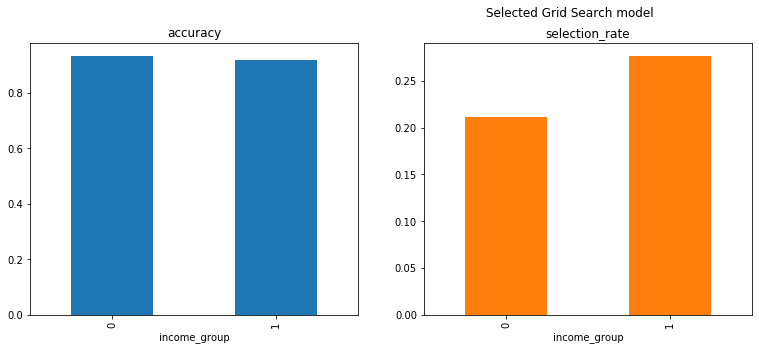

In [56]:
'''
TEST SET
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs = gs_dominant_model.predict(X_test)
metric_frame_gs = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = y_pred_gs)

gs_eo_diff = equalized_odds_difference(y_test, y_pred_gs, sensitive_features = A_test)

print(metric_frame_gs.overall)
print("-"*30)
print(metric_frame_gs.by_group)

print("accuracy:", "{:.5f}".format(metric_frame_gs.overall["accuracy"]))
print("accuracy diff:", "{:.5f}".format(metric_frame_gs.difference()["accuracy"]))
print("selection_rate:", "{:.5f}".format(metric_frame_gs.overall["selection_rate"]))
print("selection_rate diff:", "{:.5f}".format(metric_frame_gs.difference()["selection_rate"]))

print("-"*30)

model_summary.loc["grid_search", "accuracy"] = metric_frame_gs.overall["accuracy"]
model_summary.loc["grid_search", "accuracy_diff"] = metric_frame_gs.difference()["accuracy"]
model_summary.loc["grid_search", "selection_rate"] = metric_frame_gs.overall["selection_rate"]
model_summary.loc["grid_search", "selection_rate_diff"] = metric_frame_gs.difference()["selection_rate"]

metric_frame_gs.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_metric"))

Text(0.5, 1.0, 'Scatter plot of 3 models (Constraint: Equalized Odds)')

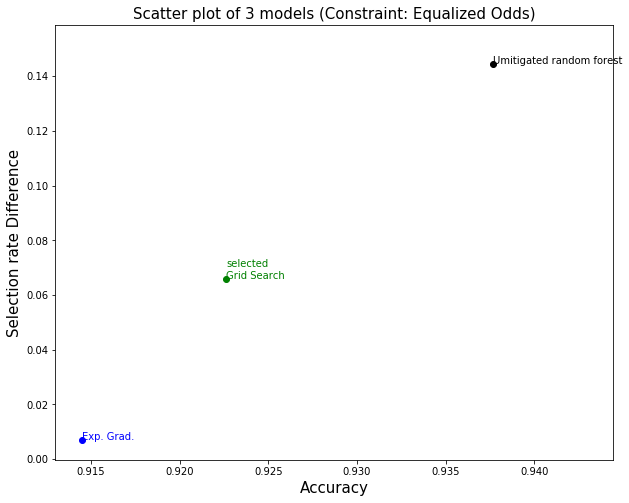

In [57]:
# plot only the dominated models

plt.figure(figsize = (10, 8))
# plt.scatter(r2_dominated, mae_diff_dominated)

# Label previous fair-unaware model
plt.scatter(metric_frame_rf_gs.overall["accuracy"], metric_frame_rf_gs.difference()["selection_rate"], color = 'black')
plt.text(metric_frame_rf_gs.overall["accuracy"], metric_frame_rf_gs.difference()["selection_rate"], "Umitigated random forest", color = 'black')

# Selected grid search model
plt.scatter(metric_frame_eg.overall["accuracy"], metric_frame_eg.difference()["selection_rate"], color = 'blue')
plt.text(metric_frame_eg.overall["accuracy"], metric_frame_eg.difference()["selection_rate"], "Exp. Grad.", color = 'blue')

# expmonentiated gradient
plt.scatter(metric_frame_gs.overall['accuracy'], metric_frame_gs.difference()["selection_rate"], color = 'green')
plt.text(metric_frame_gs.overall['accuracy'], metric_frame_gs.difference()["selection_rate"], "selected\nGrid Search", color = 'green')

plt.xlabel("Accuracy", fontsize = 15)
plt.ylabel("Selection rate Difference", fontsize = 15)
plt.title("Scatter plot of 3 models (Constraint: Equalized Odds)", fontsize = 15)
# plt.xlim((0.806, 0.811))
# plt.savefig(os.path.join(save_dir_models, CITY +"models_scatter_res"))

In [58]:
model_summary.to_csv(os.path.join(save_dir_models, CITY +"model_summary_SP.csv"))